# The Efficient Frontier

The Efficient Frontier is a concept that helps determine the optimal weights of assets in a portfolio to achieve the highest possible return for a given level of risk, or the lowest possible risk for a given level of return.

* The Efficient Frontier shows the best possible portfolios (in terms of risk vs. return) by adjusting asset weights.
* Portfolios on this frontier are considered optimal; they maximize return at each level of risk.


Let's implement the efficient frontier in python.

In [17]:
# data source : ken French data set

import pandas as pd
import numpy as np

# read the csv and parse the index column as month column

df = pd.read_csv("./data/ind30_m_vw_rets.csv", index_col = 0, header = 0) / 100
df.index = pd.to_datetime(df.index, format="%Y%m").to_period("M")
df.columns = df.columns.str.strip()

In [18]:
df.head()

Food    Beer   Smoke   Games   Books   Hshld   Clths    Hlth  \
1926-07  0.0056 -0.0519  0.0129  0.0293  0.1097 -0.0048  0.0808  0.0177   
1926-08  0.0259  0.2703  0.0650  0.0055  0.1001 -0.0358 -0.0251  0.0425   
1926-09  0.0116  0.0402  0.0126  0.0658 -0.0099  0.0073 -0.0051  0.0069   
1926-10 -0.0306 -0.0331  0.0106 -0.0476  0.0947 -0.0468  0.0012 -0.0057   
1926-11  0.0635  0.0729  0.0455  0.0166 -0.0580 -0.0054  0.0187  0.0542   

          Chems   Txtls  ...   Telcm   Servs   BusEq   Paper   Trans   Whlsl  \
1926-07  0.0814  0.0039  ...  0.0083  0.0922  0.0206  0.0770  0.0193 -0.2379   
1926-08  0.0550  0.0814  ...  0.0217  0.0202  0.0439 -0.0238  0.0488  0.0539   
1926-09  0.0533  0.0231  ...  0.0241  0.0225  0.0019 -0.0554  0.0005 -0.0787   
1926-10 -0.0476  0.0100  ... -0.0011 -0.0200 -0.0109 -0.0508 -0.0264 -0.1538   
1926-11  0.0520  0.0311  ...  0.0163  0.0377  0.0364  0.0384  0.0160  0.0467   

          Rtail   Meals     Fin   Other  
1926-07  0.0007  0.0187  0.0037  0.0520  
1926-08 -0.0075 -0.0013  0.0446  0.0676  
1926-09  0.0025 -0.0056 -0.0123 -0.0386  
1926-10 -0.0220 -0.0411 -0.0516 -0.0849  
1926-11  0.0652  0.0433  0.0224  0.0400  

[5 rows x 30 columns]

In [19]:
#to load everything on time

%load_ext autoreload
%autoreload 2
%matplotlib inline

#Our own code base

from utils import risk_kit as rk

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
df.shape

(1110, 30)

<AxesSubplot:>

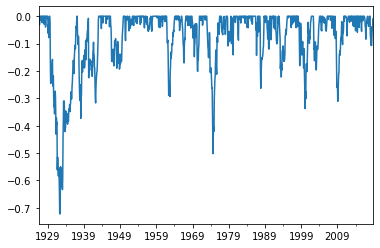

In [21]:
#Let's take a look into drawdown of food industry

rk.drawdown(df["Food"])["Drawdown"].plot()

In [22]:
# Let's look at the value at risk

rk.var_gaussian(df["Food"])

0.06822584477310774

We got 8.73% as VaR, which means 95% the lose will not be exceed VaR.

In [23]:
# Let's see the VaR for all industry

rk.var_gaussian(df, modified=True).sort_values()

Beer     0.033881
Coal     0.047359
Food     0.061207
Telcm    0.064719
Hshld    0.064886
Trans    0.065468
Servs    0.066112
Autos    0.069545
Util     0.071585
Hlth     0.071884
Paper    0.073181
Steel    0.074436
Fin      0.075199
Chems    0.079262
Txtls    0.079519
Clths    0.079707
Smoke    0.080292
Rtail    0.080437
Whlsl    0.080604
Oil      0.081244
Other    0.087270
ElcEq    0.087624
FabPr    0.088491
Books    0.088675
Cnstr    0.089668
Carry    0.094527
Meals    0.098403
BusEq    0.099377
Games    0.100701
Mines    0.102782
dtype: float64

<AxesSubplot:>

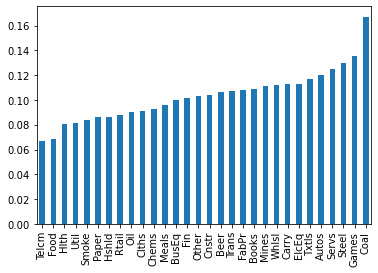

In [24]:
#Plot it in Bar chart

rk.var_gaussian(df).sort_values().plot.bar()

In [25]:
# Let's find the sharpe ration

#parameters --> (table or series, risk_free rate, period in year)

rk.sharpe_ratio(df, 0.03, 12).sort_values()

Coal     0.084275
Steel    0.126052
Whlsl    0.143494
Other    0.160862
Mines    0.177109
Books    0.192686
Games    0.194420
Txtls    0.194906
Trans    0.214624
Autos    0.227548
Cnstr    0.229351
FabPr    0.265297
Servs    0.267263
Fin      0.282243
Carry    0.285916
ElcEq    0.293063
Clths    0.293105
Util     0.306945
Hshld    0.307349
Oil      0.330358
Meals    0.332717
BusEq    0.342974
Chems    0.344903
Beer     0.351780
Rtail    0.364325
Paper    0.364722
Telcm    0.383294
Hlth     0.437783
Smoke    0.446361
Food     0.454770
dtype: float64

<AxesSubplot:>

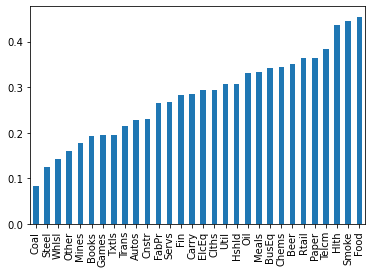

In [26]:
# Plot the sharpe ration in the plot

rk.sharpe_ratio(df, 0.03, 12).sort_values().plot.bar()

### Expected Returns and the Covariance Matrix

To compute the efficient frontier, we need expected annual return and covariance matrix. 

We can generate an estimate of expected returns using the annualize_rets() function, that returns a vector of expected returns. For instance, let's generate the set of expected returns based on historic returns from the 5 year period from 1996 through 2000:

In [27]:
df["1996":"2000"]

Food    Beer   Smoke   Games   Books   Hshld   Clths    Hlth  \
1996-01  0.0342  0.0326  0.0182  0.0469 -0.0049  0.0285 -0.0236  0.0595   
1996-02  0.0162  0.0561  0.0318  0.0179  0.0233 -0.0044  0.0187 -0.0107   
1996-03 -0.0382  0.0190 -0.0768  0.0108  0.0027  0.0130  0.1149  0.0024   
1996-04 -0.0032 -0.0089 -0.0160  0.0237  0.0285  0.0388  0.0541 -0.0060   
1996-05  0.0550  0.0969  0.0548  0.0279  0.0349  0.0325  0.0805  0.0393   
1996-06  0.0238  0.0654  0.0368 -0.0259 -0.0046  0.0122  0.0012 -0.0019   
1996-07 -0.0245 -0.0578  0.0020 -0.1182 -0.0700 -0.0332 -0.0433 -0.0606   
1996-08 -0.0040  0.0214 -0.1318  0.0030  0.0363  0.0169  0.0577  0.0419   
1996-09  0.0876  0.0073  0.0141  0.0743  0.0232  0.0634  0.0715  0.0734   
1996-10  0.0255  0.0078  0.0331 -0.0169  0.0047  0.0105 -0.0025 -0.0068   
1996-11  0.0577  0.0274  0.1074  0.0830  0.0558  0.0540 -0.0049  0.0666   
1996-12 -0.0217  0.0052  0.0930 -0.0643 -0.0210  0.0039  0.0265 -0.0266   
1997-01  0.0289  0.1136  0.0463  0.0359  0.0075  0.0643  0.0644  0.0955   
1997-02  0.0279  0.0274  0.1247 -0.0026  0.0239  0.0287  0.0312  0.0094   
1997-03 -0.0120 -0.0653 -0.1354 -0.0320  0.0071 -0.0606 -0.0566 -0.0740   
1997-04  0.0337  0.1137  0.0324  0.0275 -0.0076  0.0845 -0.0410  0.0616   
1997-05  0.0257  0.0643  0.0998  0.0560  0.0706  0.0815  0.0501  0.0691   
1997-06  0.0654  0.0007  0.0267  0.0141  0.0610  0.0417  0.0360  0.0889   
1997-07  0.0571  0.0185  0.0130  0.0178  0.0486  0.0443  0.0311  0.0206   
1997-08 -0.0415 -0.1261 -0.0304 -0.0251 -0.0254 -0.0826 -0.0618 -0.0614   
1997-09  0.0639  0.0811 -0.0278  0.0510  0.0722  0.0511  0.0507  0.0661   
1997-10 -0.0153 -0.0595 -0.0416 -0.0027 -0.0099 -0.0371 -0.0795  0.0026   
1997-11  0.0749  0.0729  0.0865  0.0748  0.0393  0.0553  0.0148  0.0286   
1997-12  0.0323  0.0420  0.0538  0.0251  0.0622  0.0298 -0.0897  0.0355   
1998-01 -0.0380 -0.0203 -0.0735  0.0637 -0.0066  0.0080  0.0041  0.0573   
1998-02  0.0445  0.0469  0.0450  0.0577  0.0631  0.0910  0.1162  0.0545   
1998-03  0.0423  0.1245 -0.0326 -0.0040  0.0532  0.0424  0.0426  0.0361   
1998-04 -0.0321 -0.0308 -0.1083  0.0863  0.0162  0.0106  0.0271  0.0192   
1998-05  0.0108  0.0288  0.0059 -0.0651 -0.0077 -0.0121 -0.0078 -0.0247   
1998-06 -0.0025  0.0671  0.0552 -0.0260  0.0597  0.0367  0.0215  0.0618   
1998-07 -0.0777 -0.0449  0.1037 -0.0237 -0.0271 -0.0348 -0.1018 -0.0022   
1998-08 -0.0896 -0.1976 -0.0520 -0.2216 -0.1040 -0.1092 -0.2215 -0.1226   
1998-09  0.0437 -0.0502  0.1246 -0.0138 -0.0033 -0.0511  0.0253  0.1201   
1998-10  0.0920  0.1576  0.1082  0.0696  0.0737  0.1854  0.0686  0.0385   
1998-11  0.0434  0.0579  0.0915  0.1257  0.0836  0.0109  0.0336  0.0618   
1998-12 -0.0164 -0.0031 -0.0304 -0.0308  0.0945  0.0540  0.0380  0.0502   
1999-01 -0.0379 -0.0165 -0.1221  0.0819 -0.0098 -0.0209  0.0697  0.0024   
1999-02 -0.0375 -0.0134 -0.1597  0.0505 -0.0016 -0.0127  0.0195  0.0023   
1999-03 -0.0330 -0.0165 -0.0893 -0.0501  0.0293  0.0495  0.0149  0.0255   
1999-04  0.0099  0.0503  0.0007  0.0489  0.0580  0.0423  0.0860 -0.0554   
1999-05  0.0388 -0.0063  0.0996 -0.0555 -0.0146 -0.0301 -0.0255 -0.0205   
1999-06  0.0069 -0.0431  0.0486  0.0546  0.0403  0.0133  0.0159  0.0449   
1999-07 -0.0390  0.0026 -0.0688 -0.0657 -0.0042 -0.0106 -0.0989 -0.0444   
1999-08 -0.0229 -0.0385  0.0055 -0.0187 -0.0944  0.0262 -0.1112  0.0373   
1999-09 -0.0472 -0.1494 -0.0691 -0.0310  0.0133 -0.0976  0.0470 -0.0709   
1999-10  0.0870  0.1641 -0.2493  0.0136  0.1015  0.1153  0.0025  0.1078   
1999-11 -0.0672  0.0885  0.0352  0.0662 -0.0809  0.0012 -0.1036  0.0150   
1999-12 -0.0567 -0.0883 -0.1015  0.0710  0.1276  0.0417  0.0392 -0.0564   
2000-01 -0.0829 -0.0228 -0.0862  0.0229 -0.0092 -0.0651 -0.1138  0.0756   
2000-02 -0.0689 -0.1164 -0.0401 -0.0177 -0.0071 -0.1157 -0.1278 -0.0288   
2000-03  0.0969  0.0013  0.0511  0.1052  0.1293 -0.1426  0.2506  0.0028   
2000-04 -0.0390  0.0368  0.0379  0.0220 -0.0734  0.0429  0.0430  0.0525   
2000-05  0.1565  0.1187  0.1951  0.0

In [28]:
# let's compute the annualize return

# industry list
l = ["Food", "Beer", "Smoke", "Coal"]

rets = rk.annualize_rets(df["1996":"2000"], 12)
rets

Food     0.116799
Beer     0.141126
Smoke    0.107830
Games    0.068212
Books    0.187286
Hshld    0.134766
Clths    0.079160
Hlth     0.246641
Chems    0.077456
Txtls   -0.042721
Cnstr    0.084076
Steel    0.115809
FabPr    0.108280
ElcEq    0.272420
Autos    0.080954
Carry    0.173904
Mines   -0.053554
Coal     0.414689
Oil      0.165377
Util     0.145903
Telcm    0.122771
Servs    0.175264
BusEq    0.271952
Paper    0.097163
Trans    0.071099
Whlsl    0.126431
Rtail    0.207247
Meals    0.067400
Fin      0.223371
Other    0.043349
dtype: float64

In [44]:
# subset of 4 industry 

portfolio = df["1996":"2000"][l]
portfolio

Food    Beer   Smoke    Coal
1996-01  0.0342  0.0326  0.0182 -0.0234
1996-02  0.0162  0.0561  0.0318  0.0182
1996-03 -0.0382  0.0190 -0.0768  0.0453
1996-04 -0.0032 -0.0089 -0.0160  0.0064
1996-05  0.0550  0.0969  0.0548  0.1573
1996-06  0.0238  0.0654  0.0368  0.0935
1996-07 -0.0245 -0.0578  0.0020 -0.0838
1996-08 -0.0040  0.0214 -0.1318  0.0116
1996-09  0.0876  0.0073  0.0141  0.1033
1996-10  0.0255  0.0078  0.0331  0.0103
1996-11  0.0577  0.0274  0.1074  0.0408
1996-12 -0.0217  0.0052  0.0930  0.1131
1997-01  0.0289  0.1136  0.0463  0.1226
1997-02  0.0279  0.0274  0.1247 -0.0326
1997-03 -0.0120 -0.0653 -0.1354 -0.0540
1997-04  0.0337  0.1137  0.0324  0.0674
1997-05  0.0257  0.0643  0.0998 -0.0465
1997-06  0.0654  0.0007  0.0267  0.0288
1997-07  0.0571  0.0185  0.0130  0.1080
1997-08 -0.0415 -0.1261 -0.0304 -0.0522
1997-09  0.0639  0.0811 -0.0278 -0.0438
1997-10 -0.0153 -0.0595 -0.0416 -0.1721
1997-11  0.0749  0.0729  0.0865 -0.0703
1997-12  0.0323  0.0420  0.0538  0.0359
1998-01 -0.0380 -0.0203 -0.0735 -0.1073
1998-02  0.0445  0.0469  0.0450  0.0878
1998-03  0.0423  0.1245 -0.0326  0.0566
1998-04 -0.0321 -0.0308 -0.1083  0.0094
1998-05  0.0108  0.0288  0.0059 -0.0167
1998-06 -0.0025  0.0671  0.0552 -0.0222
1998-07 -0.0777 -0.0449  0.1037  0.0852
1998-08 -0.0896 -0.1976 -0.0520 -0.2469
1998-09  0.0437 -0.0502  0.1246  0.0520
1998-10  0.0920  0.1576  0.1082  0.0296
1998-11  0.0434  0.0579  0.0915  0.0611
1998-12 -0.0164 -0.0031 -0.0304  0.2261
1999-01 -0.0379 -0.0165 -0.1221  0.1916
1999-02 -0.0375 -0.0134 -0.1597  0.0628
1999-03 -0.0330 -0.0165 -0.0893  0.2983
1999-04  0.0099  0.0503  0.0007  0.2295
1999-05  0.0388 -0.0063  0.0996 -0.1225
1999-06  0.0069 -0.0431  0.0486 -0.2306
1999-07 -0.0390  0.0026 -0.0688 -0.1065
1999-08 -0.0229 -0.0385  0.0055  0.1145
1999-09 -0.0472 -0.1494 -0.0691 -0.1102
1999-10  0.0870  0.1641 -0.2493  0.2443
1999-11 -0.0672  0.0885  0.0352 -0.0147
1999-12 -0.0567 -0.0883 -0.1015  0.1973
2000-01 -0.0829 -0.0228 -0.0862  0.4052
2000-02 -0.0689 -0.1164 -0.0401 -0.0345
2000-03  0.0969  0.0013  0.0511 -0.0724
2000-04 -0.0390  0.0368  0.0379 -0.1533
2000-05  0.1565  0.1187  0.1951 -0.1262
2000-06  0.0234  0.0605  0.0296  0.1480
2000-07 -0.0088  0.0657 -0.0439  0.1138
2000-08 -0.0266 -0.1083  0.1903  0.1776
2000-09  0.0490  0.0546  0.0087 -0.1372
2000-10  0.0607  0.0899  0.2280  0.0716
2000-11  0.0444  0.0420  0.0407  0.0924
2000-12  0.0551 -0.0257  0.1696  0.4404

In [84]:
# Generate covariance matrix

#python is having inbuild function to generate covariance

cov = df["1996":"2000"].cov()
#cov.loc[["Games","Fin"],["Games","Fin"]]

In [46]:
# Portfolio return is dot product of Weights and returns

def portfolio_return(weights, returns):
    """
    Computes the return on a portfolio from constituent returns and weights
    weights are a numpy array or Nx1 matrix and returns are a numpy array or Nx1 matrix
    """
    return weights.T @ returns

# Portfolio volatility is dot product of weights, covariance matrix and weights

def portfolio_vol(weights, covmat):
    """
    Computes the vol of a portfolio from a covariance matrix and constituent weights
    weights are a numpy array or N x 1 maxtrix and covmat is an N x N matrix
    """
    return (weights.T @ covmat @ weights)**0.5

In [47]:
# Weights - Each 25%

ew = np.repeat(0.25, 4)


In [48]:
# Compute the portfolio return with given weight

portfolio_return(ew, rets[l])

0.19511097196038385

In [71]:
# Portfolio volatility

portfolio_vol(ew, cov.loc[l,l])

0.05637039497141906

# The 2-Asset Case

In the case of 2 asset problem, the weight distrubution is simple. We have to choose one asset weight, the another one weight could be 1 - (1st asset). 

In [52]:
import numpy as np

n_points = 20
weights = [np.array([w, 1-w]) for w in np.linspace(0, 1, n_points)]
weights

[array([0., 1.]),
 array([0.05263158, 0.94736842]),
 array([0.10526316, 0.89473684]),
 array([0.15789474, 0.84210526]),
 array([0.21052632, 0.78947368]),
 array([0.26315789, 0.73684211]),
 array([0.31578947, 0.68421053]),
 array([0.36842105, 0.63157895]),
 array([0.42105263, 0.57894737]),
 array([0.47368421, 0.52631579]),
 array([0.52631579, 0.47368421]),
 array([0.57894737, 0.42105263]),
 array([0.63157895, 0.36842105]),
 array([0.68421053, 0.31578947]),
 array([0.73684211, 0.26315789]),
 array([0.78947368, 0.21052632]),
 array([0.84210526, 0.15789474]),
 array([0.89473684, 0.10526316]),
 array([0.94736842, 0.05263158]),
 array([1., 0.])]

<AxesSubplot:xlabel='V'>

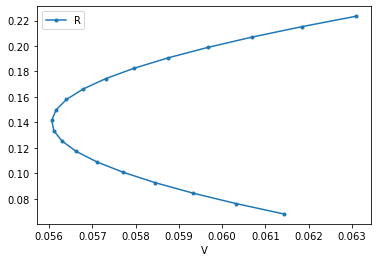

In [98]:
l2 = ["Games","Fin"]

#subset of 2 industry

# Find the annualise return for the two industry
return2 = [portfolio_return(w, rets[l2]) for w in weights]

# Find the volatility for 2 industry
vol2 = [portfolio_vol(w, cov.loc[l2,l2]) for w in weights]
ef = pd.DataFrame({"R": return2, "V": vol2})
ef.plot.line(x="V", y="R", style=".-")